

**Problem Statement:**

Goal: Create a unified hybrid framework that adapts to the commodity type and automatically selects or combines the best models accordingly.

We loaded historical data from 2003-April 2025 alonmg with new realtime data to predict price with pre trained model.

## Step 8 Processing Real Time Data with Pre Trained Models

##### Sourcing Key Libraries


In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import os
import itertools
import requests
import yfinance as yf
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
#from arch import arch_model
from transformers import pipeline
#from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### Define constant Variables

In [2]:
# constant values
# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'
# API Key for Alpha Vantage (Replace with your actual key)
API_KEY_alpha = "3J4EGZCB0D7UT9WG"
# genertae your APi key from here: https://www.alphavantage.co/

#update the below code for any new precious Metal

data_ticker_map = {
            'GOLD' : 'GC=F',
            'SILVER': 'SI=F',
            'CRUDE_OIL': 'CL=F'}

data_file_mapping = {
            'GOLD' : '../../Data/Historical_Gold_data_April_2020_2.csv',
           'SILVER': '../../Data/Historical_Silver_data_April.csv',
           'CRUDE_OIL': '../../Data/Historical_Crude_oil_data_April.csv',}

Live_Sentiments_file_name = 'real-Live_Sentiments.csv'
Live_Sentiments_file_dir = '../../Sentiments'
Historical_Sentiments_file_name = 'Historical_Sentiments.csv'
Historical_Sentiments_file_dir = '../../Sentiments'

best_models_dir = {'GOLD': '../../Models/GOLD_MODELS', 'SILVER' : '../../Models/SILVER_MODELS', 'CRUDE_OIL': '../../Models/CRUDE_OIL_MODELS'}
hybrid_models_dir = {'GOLD': '../../Models/GOLD_HYBRID_MODELS', 'SILVER' : '../../Models/SILVER_HYBRID_MODELS', 'CRUDE_OIL': '../../Models/CRUDE_OIL_HYBRID_MODELS'}
hybrid_meta_models_dir = {'GOLD': '../../Models/GOLD_HYBRID_MODELS/Meta', 'SILVER' : '../../Models/SILVER_HYBRID_MODELS/Meta', 'CRUDE_OIL': '../../Models/CRUDE_OIL_HYBRID_MODELS/Meta'}

### Enter Commodity Name for which you want to predict Price EX: GOLD, SILVER, CRUDE OIL etc

In [44]:
commodity = input('Enter the Commodity Name')
filename =  data_file_mapping.get(commodity)
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')

Enter the Commodity Name SILVER


Loading from Historical file id Data available in file : ../../Data/Historical_Silver_data_April.csv
Ticker code for SILVER : SI=F


In [106]:
d = '45' #input('Enter the number of Days/Hours you eant to predict from real time 30,15,90')
days = int(d)
realtimedays = d+'d'
realtimedays

'45d'

## Data Sourcing

### Historical Data Sourcing

##### Yahoo finance is not reliable and having issues, download data from 2003-01-01 - 2025-03-15 via yf api.

##### Define function to download Historical data 

In [107]:
# Function to download historical price data
def download_price_data(ticker, start='2003-01-01', end='2025-04-28'):
    # Download the data
    data = yf.download(ticker, start=start, end=end)
    
    # Reset index to turn 'Date' into a regular column
    data.reset_index(inplace=True)
    
    # Flatten the columns if there are multiple levels
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    
    # Select necessary columns only
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    return data

# Load or download data for each commodity
def load_or_download_data(ticker, filename):
    if os.path.exists(filename):
        # Read the CSV, treating the first row as the header
        data = pd.read_csv(filename, header=0)
        
        # Convert 'Date' column to datetime format, and handle parsing errors
        data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
        
        # Remove any rows where 'Date' could not be parsed and resulted in NaT
        data = data.dropna(subset=['Date'])
    else:
        # Download the data
        data = download_price_data(ticker)
        
        # Save to CSV with a single header row
        data.to_csv(filename, index=False)
    
    # Ensure the 'Close' column is numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    
    return data


In [108]:
############# Reading Data Sources #################
print(f'Loading from Historical file id Data available in file : {filename}')
ticker = data_ticker_map.get(commodity)
print(f'Ticker code for {commodity} : {ticker}')
commodity_data = load_or_download_data(ticker, filename)

Loading from Historical file id Data available in file : ../../Data/Historical_Silver_data_April.csv
Ticker code for SILVER : SI=F


### Fetch Realtime Data

In [109]:
# Function to fetch real-time data
def fetch_real_time_data(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    data.columns = data.columns.get_level_values(0) if isinstance(data.columns, pd.MultiIndex) else data.columns
    data.columns.name = None
    data.index = pd.to_datetime(data.index).date
    # Select and standardize the required columns
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    return data

### Merge Historical Data with Realtime Data

In [110]:

real_time_data = fetch_real_time_data(ticker, period=realtimedays, interval='1h')
# Convert index to Date column
real_time_data['Date'] = real_time_data.index
# Reset index
real_time_data.reset_index(drop=True, inplace=True)
# Ensure 'Date' is datetime without timezone
real_time_data['Date'] = pd.to_datetime(real_time_data['Date']).dt.normalize()
# Reorder columns
real_time_data = real_time_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Print output
print(real_time_data.head())
# ######## Combine Real TIme data with Historical data
commodity_data = pd.concat([commodity_data,real_time_data])
commodity_data = commodity_data.drop_duplicates(subset='Date', keep='first')

[*********************100%***********************]  1 of 1 completed

        Date       Open       High        Low      Close  Volume
0 2025-03-11  32.555000  32.615002  32.520000  32.610001       0
1 2025-03-11  32.610001  32.625000  32.465000  32.525002     855
2 2025-03-11  32.529999  32.660000  32.270000  32.650002    1229
3 2025-03-11  32.650002  32.674999  32.595001  32.660000    1046
4 2025-03-11  32.660000  32.845001  32.634998  32.840000    1855


In [111]:
commodity_data


,Date,Open,High,Low,Close,Volume
0,2020-01-02,17.966000,17.990000,17.966000,17.966000,2
1,2020-01-03,18.110001,18.110001,17.965000,18.068001,83
2,2020-01-06,18.025000,18.105000,18.025000,18.097000,3
3,2020-01-07,18.014999,18.344999,18.014999,18.316000,33
4,2020-01-08,18.400000,18.504999,18.070000,18.087999,31
...,...,...,...,...,...,...
755,2025-04-28,32.855000,32.930000,32.820000,32.930000,342
778,2025-04-29,33.020000,33.075001,33.005001,33.075001,79
801,2025-04-30,33.195000,33.294998,32.950001,33.270000,1043
824,2025-05-01,32.814999,32.865002,32.215000,32.535000,2455


### Sourcing Market data

####  GDP data

##### Define function which will convert Yearly GDP data to daily GDP data

In [112]:
def expand_gdp_to_daily(gdp_df):
    daily_gdp = []
    for index, row in gdp_df.iterrows():
        month_start = row['Date']
        value = row['Value']
        month_days = pd.date_range(start=month_start, end=month_start + pd.offsets.MonthEnd(0), freq='D')
        for day in month_days:
            daily_gdp.append({'Date': day, 'Value': value})
    return pd.DataFrame(daily_gdp)


def preprocess_gdp_data(gdp_data):
    gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
    return expand_gdp_to_daily(gdp_data)


def fetch_world_bank_data(indicator, country='USA', start_year='2003', end_year='2024'):
    url = f'http://api.worldbank.org/v2/country/{country}/indicator/{indicator}?date={start_year}:{end_year}&format=json'
    try:
        response = requests.get(url)
        data = response.json()
        if len(data) < 2 or 'message' in data[1]:
            print("No data found for the specified parameters.")
            return None
        df = pd.json_normalize(data[1])
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= f'{start_year}-01-01') & (df['date'] <= f'{end_year}-12-31')]
        df = df[['date', 'value']]
        df.columns = ['Date', 'Value']
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None


In [113]:
############### sourcing world GDP data #################################################
gdp_data = fetch_world_bank_data('NY.GDP.MKTP.CD', country='USA', start_year='2003', end_year='2024')
daily_gdp_data = preprocess_gdp_data(gdp_data)
daily_gdp_data.rename(columns={'Value':'GDP'},inplace=True)
daily_gdp_data

,Date,GDP
0,2024-01-01,NaT
1,2024-01-02,NaT
2,2024-01-03,NaT
3,2024-01-04,NaT
4,2024-01-05,NaT
...,...,...
677,2003-01-27,11456450000000.0
678,2003-01-28,11456450000000.0
679,2003-01-29,11456450000000.0
680,2003-01-30,11456450000000.0


####  Interest rate data

In [114]:

############## Sourcing Interest rate data ################################
from fredapi import Fred

# Your API Key from FRED
api_key = 'a27b910873da479a5561ea08035a6c79'

# Initialize the FRED API
fred = Fred(api_key=api_key)

# Fetch the Federal Funds Rate data (you can change this to any other indicator)
# Federal Funds Rate is often identified by the FRED ID 'FEDFUNDS'
interest_rate_data = fred.get_series('FEDFUNDS' ,start_date='2003-01-01')

# Convert the data into a DataFrame for better handling
interest_rate_df = pd.DataFrame(interest_rate_data)
interest_rate_df.columns = ['Interest_rates']

# Reset the index to have 'Date' as a column
interest_rate_df.reset_index(inplace=True)

import pandas as pd

# Assuming `interest_rate_df` already exists with 'Date' and 'Interest_rates' columns

# Convert 'Date' column to datetime format if it’s not already
interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['index'])
interest_rate_df.drop(columns=['index'], inplace=True)  # Drop the old index column if needed

# Create a date range for every day from the start to the end of the interest rate data
start_date = interest_rate_df['Date'].min()
end_date = interest_rate_df['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_interest_rate_df = pd.DataFrame({'date': date_range})

# Add a 'month' and 'year' column to `interest_rate_df` for easy merging
interest_rate_df['year'] = interest_rate_df['Date'].dt.year
interest_rate_df['month'] = interest_rate_df['Date'].dt.month

# Merge monthly data with daily data on matching 'year' and 'month'
daily_interest_rate_df['year'] = daily_interest_rate_df['date'].dt.year
daily_interest_rate_df['month'] = daily_interest_rate_df['date'].dt.month

# Perform a left join on 'year' and 'month' columns
daily_interest_rate_df = daily_interest_rate_df.merge(
    interest_rate_df[['year', 'month', 'Interest_rates']],
    on=['year', 'month'],
    how='left'
)

# Drop the extra columns, keep only 'date' and 'Interest_rates'
daily_interest_rate_data = daily_interest_rate_df[['date', 'Interest_rates']]
daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)
daily_interest_rate_data


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25220\1493415932.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_interest_rate_data.rename(columns={'date':'Date'},inplace=True)


,Date,Interest_rates
0,1954-07-01,0.80
1,1954-07-02,0.80
2,1954-07-03,0.80
3,1954-07-04,0.80
4,1954-07-05,0.80
...,...,...
25838,2025-03-28,4.33
25839,2025-03-29,4.33
25840,2025-03-30,4.33
25841,2025-03-31,4.33


####  GDP to Debt data

In [115]:
################## GDP to Debt DATA ###############################
import wbdata
import pandas as pd
import datetime

# Set the start and end dates for the data
start_date = datetime.datetime(2000, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# List of indicators to retrieve (Government Debt to GDP ratio)
indicators = {'GC.DOD.TOTL.GD.ZS': 'Government Debt to GDP'}

# Fetch data from the World Bank API for the USA
government_debt_data = wbdata.get_dataframe(indicators, country='USA')

# Fill missing values in `Government Debt to GDP` with 0
government_debt_data['Government Debt to GDP'] = government_debt_data['Government Debt to GDP'].fillna(0)

# Reset index to make `date` a regular column and convert it to datetime
government_debt_data.reset_index(inplace=True)
government_debt_data['date'] = pd.to_datetime(government_debt_data['date'])

# Add a 'year' column to `government_debt_data` to help with mapping
government_debt_data['year'] = government_debt_data['date'].dt.year

# Create a dictionary for quick lookup of Debt to GDP per year
debt_to_gdp_dict = government_debt_data.set_index('year')['Government Debt to GDP'].to_dict()

# Create a date range for every day from the start to the end date
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a new DataFrame with daily dates as a column
daily_debt_data = pd.DataFrame({'date': date_range})

# Map each date in `daily_debt_data` to the corresponding Debt to GDP value for that year
daily_debt_data['DebtToGDP'] = daily_debt_data['date'].dt.year.map(debt_to_gdp_dict)
daily_debt_data.rename(columns={'date':'Date'},inplace=True)

daily_debt_data

,Date,DebtToGDP
0,2000-01-01,33.267642
1,2000-01-02,33.267642
2,2000-01-03,33.267642
3,2000-01-04,33.267642
4,2000-01-05,33.267642
...,...,...
8397,2022-12-28,110.385332
8398,2022-12-29,110.385332
8399,2022-12-30,110.385332
8400,2022-12-31,110.385332


####  Inflation data

In [116]:
############## inflation data #################
# Get historical CPI data (Consumer Price Index) to calculate inflation
cpi_data = fred.get_series('CPIAUCSL', start_date='2003-01-01')



# Convert the data into a DataFrame for better handling
Inflation_data = pd.DataFrame(interest_rate_data)
Inflation_data.columns = ['Inflation_rate']

# Reset the index to have 'Date' as a column
Inflation_data.reset_index(inplace=True)
Inflation_data.rename(columns={'index':'Date'},inplace=True)
# Print the first few rows
Inflation_data

,Date,Inflation_rate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
845,2024-12-01,4.48
846,2025-01-01,4.33
847,2025-02-01,4.33
848,2025-03-01,4.33


####  ETF data

In [117]:
################ Gold ETF data ###########################################
import requests
import pandas as pd

# Fetch ETF data from FRED API
def fetch_fred_etf_data(series_id, api_key, start_date='2003-01-01', end_date='2024-11-01'):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}'
    response = requests.get(url)
    data = response.json()
    
    # Print the entire JSON response for inspection
    print("Full JSON response:", data)
    
    # Check for errors in the JSON response
    if "observations" not in data:
        print("Error: 'observations' key not found in the response. Check the series ID or API request.")
        return None
    
    # Parse JSON data into a DataFrame
    etf_df = pd.DataFrame(data['observations'])
    etf_df['Date'] = pd.to_datetime(etf_df['date'])
    etf_df['Date'] = etf_df['Date'].dt.tz_localize(None).dt.date 
    etf_df['value'] = pd.to_numeric(etf_df['value'], errors='coerce')
    etf_df.set_index('Date', inplace=True)
    
    return etf_df

# Example usage
api_key = 'a27b910873da479a5561ea08035a6c79'
series_id = 'INTDSRUSM193N'  # Replace with a valid series ID from FRED
etf_data = fetch_fred_etf_data(series_id, api_key)


etf_data.rename(columns={'value':'ETF_Value'},inplace=True)
# Only print if data retrieval was successful
if etf_data is not None:
    print(etf_data.head())

Full JSON response: {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'observation_start': '2003-01-01', 'observation_end': '2024-11-01', 'units': 'lin', 'output_type': 1, 'file_type': 'json', 'order_by': 'observation_date', 'sort_order': 'asc', 'count': 224, 'offset': 0, 'limit': 100000, 'observations': [{'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-01-01', 'value': '2.25'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-02-01', 'value': '2.25'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-03-01', 'value': '2.25'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-04-01', 'value': '2.25'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-05-01', 'value': '2.25'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'date': '2003-06-01', 'value': '2'}, {'realtime_start': '2025-04-12', 'realtime_end': '2025-04-12', 'd

## Sourcing Sentiment Data and Apply BERT

#### Sourcing Live Sentiments

In [118]:
import requests
import pandas as pd
from transformers import pipeline
from datetime import datetime, timedelta

# Set up NewsAPI
API_KEY = "250e051931514de6b0e5120412c4e3ad"
NEWS_API_URL = "https://newsapi.org/v2/everything"

# Fetch news using query
def fetch_news(query, language="en", page_size=100):
    params = {
        "q": query,
        "language": language,
        "apiKey": API_KEY,
        "pageSize": page_size,
        "sortBy": "publishedAt",
    }
    response = requests.get(NEWS_API_URL, params=params)
    data = response.json()
    
    if data.get("status") == "ok":
        articles = data.get("articles", [])
        return [(article["publishedAt"], article["title"]) for article in articles]
    else:
        print("Error fetching news:", data)
        return []

# Load FinBERT pipeline
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

def analyze_sentiment(texts):
    sentiments = sentiment_pipeline(texts, truncation=True)
    return [sent["label"] for sent in sentiments]

# Combined sentiment fetcher for crude oil-related queries
def get_silver_sentiment():
    queries =  [
    "silver price",
    "silver futures",
    "silver market",
    "silver trading",
    "silver commodity",
    "silver ETF",
    "precious metals",
    "silver demand",
    "silver mining"
]
    all_articles = []

    for query in queries:
        articles = fetch_news(query)
        all_articles.extend(articles)

    if not all_articles:
        return pd.DataFrame()

    df = pd.DataFrame(all_articles, columns=["Date", "Headline"])
    df["Sentiment"] = analyze_sentiment(df["Headline"].tolist())
    df.to_csv("silver_sentiment_data.csv", index=False)
    return df


#### Apply Sentiment analysis on Live data and save them in disk

In [119]:
# Save the new data
import os
Live_Sentiments_file = os.path.join(Live_Sentiments_file_dir, commodity.upper(), Live_Sentiments_file_name)
if os.path.exists(Live_Sentiments_file):
        # sentiment_df = get_silver_sentiment()
        # sentiment_df.to_csv(Live_Sentiments_file, index=False)
        sentiment_df =  pd.read_csv(Live_Sentiments_file)  # File does not exist
else:
    # Fetch sentiment data
    sentiment_df = get_silver_sentiment()
    sentiment_df.to_csv(Live_Sentiments_file, index=False)
print(sentiment_df.head())
sentiment_df['Sentiment_score'] = sentiment_df['Sentiment'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
print(sentiment_df.head())

# Add sentiment data back to the news_df
sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
live_sentiments_df = sentiment_df[['Date', 'Headline', 'Sentiment', 'Sentiment_score']]
# # Print out the resulting dataframe
# print(news_df[['Date', 'Title', 'Sentiment']].head())

# Convert Date column to datetime and add a range of days around each event
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])



live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'], errors='coerce')
live_sentiments_df['Date'] = live_sentiments_df['Date'].dt.tz_localize(None).dt.date 
live_sentiments_df.head()

                   Date                                           Headline  \
0  2025-05-02T05:26:50Z  Analysts Set Hudbay Minerals Inc. (NYSE:HBM) P...   
1  2025-05-02T05:26:49Z  Analysts Set Sibanye Stillwater Limited (NYSE:...   
2  2025-05-02T05:06:51Z  Perpetua Resources (PPTA) Projected to Post Ea...   
3  2025-05-02T05:03:41Z  GWM Tank 500 HEV to be launched in Malaysia May 8   
4  2025-05-02T03:25:00Z  Bunker Hill Announces Amendments to Outstandin...   

  Sentiment  
0   neutral  
1   neutral  
2  positive  
3   neutral  
4   neutral  
                   Date                                           Headline  \
0  2025-05-02T05:26:50Z  Analysts Set Hudbay Minerals Inc. (NYSE:HBM) P...   
1  2025-05-02T05:26:49Z  Analysts Set Sibanye Stillwater Limited (NYSE:...   
2  2025-05-02T05:06:51Z  Perpetua Resources (PPTA) Projected to Post Ea...   
3  2025-05-02T05:03:41Z  GWM Tank 500 HEV to be launched in Malaysia May 8   
4  2025-05-02T03:25:00Z  Bunker Hill Announces Amendments

,Date,Headline,Sentiment,Sentiment_score
0,2025-05-02,Analysts Set Hudbay Minerals Inc. (NYSE:HBM) P...,neutral,0
1,2025-05-02,Analysts Set Sibanye Stillwater Limited (NYSE:...,neutral,0
2,2025-05-02,Perpetua Resources (PPTA) Projected to Post Ea...,positive,1
3,2025-05-02,GWM Tank 500 HEV to be launched in Malaysia May 8,neutral,0
4,2025-05-02,Bunker Hill Announces Amendments to Outstandin...,neutral,0


#### Load Historical Sentiment data

In [120]:
Historical_Sentiments_file = os.path.join(Historical_Sentiments_file_dir, commodity.upper(), Historical_Sentiments_file_name)
#Detect Invalid Dates
def is_invalid_date(date_str):
    try:
        pd.to_datetime(date_str, format="%d-%m-%Y", errors="raise")
        return False  # Valid date
    except:
        return True   # Invalid date



if os.path.exists(Historical_Sentiments_file) and commodity.upper()=="GOLD":
        historical_news_df =  pd.read_csv(Historical_Sentiments_file)  # File does not exist
        print(historical_news_df)
elif commodity.upper()=="GOLD" :
    # Fetch sentiment data
    historical_sentiment_data = pd.read_csv("C:/Users/Lenovo/OneDrive/Desktop/War/code/data/gold_historical_sentiments.csv", usecols=["Dates","Price Sentiment", "News"])
    historical_sentiment_data = historical_sentiment_data[~historical_sentiment_data["Dates"].astype(str).apply(is_invalid_date)]
    
    
    # Add sentiment data back to the news_df
    # # Print out the resulting dataframe
    # print(news_df[['Date', 'Title', 'Sentiment']].head())
    historical_news_df = historical_sentiment_data[['Dates', 'News', 'Price Sentiment', 'Sentiment_score']]
    historical_news_df.rename(columns = {'News':'Headline', 'Dates':'Date', 'Price Sentiment':'Sentiment'}, inplace = True)
    
    # Convert Date column to datetime and add a range of days around each event
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])
    historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'], errors='coerce')
    historical_news_df['Date'] = historical_news_df['Date'].dt.tz_localize(None).dt.date 

    historical_news_df = historical_news_df[['Date','Headline']]
    historical_news_df["Sentiment_score"] = analyze_sentiment(historical_news_df["Headline"].tolist(), batch_size=16)
    historical_news_df['Sentiment_score'] = historical_news_df['Sentiment_score'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)
    historical_news_df.to_csv(Historical_Sentiments_file, index=False)
else:
    historical_news_df=live_sentiments_df




## Step 2 : Data Preprocessing and Cleaning

### 2.1 Null Value Treatment

In [121]:
for data in [commodity_data]:
    data.dropna(subset=['Date', 'Close'], inplace=True)

### 2.2 Converting Values to Datetime format

In [122]:
# COnvert into date format
# Historical Data
# Convert Date column in gold_data to remove timezone
commodity_data['Date'] = commodity_data['Date'].dt.tz_localize(None).dt.date 

# Market Economic Data
daily_gdp_data['Date'] = daily_gdp_data['Date'].dt.tz_localize(None).dt.date 
interest_rate_df['Date'] = interest_rate_df['Date'].dt.tz_localize(None).dt.date 
Inflation_data['Date'] = Inflation_data['Date'].dt.tz_localize(None).dt.date 
daily_debt_data['Date'] = daily_debt_data['Date'].dt.tz_localize(None).dt.date 

### 2.3 Merging all source data to final data frame

In [123]:
# Merge all dataframes on 'Date' with 'gold_data' as the base (left join)
merged_data = commodity_data.merge(daily_gdp_data, on='Date', how='left') \
                       .merge(interest_rate_df, on='Date', how='left') \
                       .merge(Inflation_data, on='Date', how='left') \
                       .merge(daily_debt_data, on='Date', how='left') \
                        .merge(etf_data[['ETF_Value']], on='Date', how='left')

merged_data.drop(columns=['year','month'],inplace=True)

In [124]:
merged_data.info()
# Print summary of missing values after imputation
print(merged_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1349 non-null   object 
 1   Open            1349 non-null   float64
 2   High            1349 non-null   float64
 3   Low             1349 non-null   float64
 4   Close           1349 non-null   float64
 5   Volume          1349 non-null   int64  
 6   GDP             80 non-null     object 
 7   Interest_rates  42 non-null     float64
 8   Inflation_rate  42 non-null     float64
 9   DebtToGDP       756 non-null    float64
 10  ETF_Value       12 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 116.1+ KB
Date                 0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
GDP               1269
Interest_rates    1307
Inflation_rate    1307
DebtToGDP          593
ETF_Value     

### 2.4 Processing NULL values from merged data

In [125]:

# Convert numeric columns from object type to float (if needed)
numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
merged_data[numeric_cols] = merged_data[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Handle Financial Market Data (Time-series features)
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)

#  Handle Volume (Typically Skewed, Use Median)
merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)

# 🔹 Handle Economic Indicators (Use Mean or Interpolation)
econ_cols = ["GDP", "DebtToGDP", "Interest_rates", "Inflation_rate", "ETF_Value"]
for col in econ_cols:
    merged_data[col].fillna(merged_data[col].mean(), inplace=True)  # Mean Imputation
    merged_data[col].fillna(0, inplace=True)  # Mean Imputation


# Print summary of missing values after imputation
print(merged_data.isnull().sum())

commodity_data=merged_data

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
GDP               0
Interest_rates    0
Inflation_rate    0
DebtToGDP         0
ETF_Value         0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25220\3625551758.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[numeric_cols] = merged_data[numeric_cols].fillna(method="ffill")  # Forward Fill (Recommended)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25220\3625551758.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data["Volume"].fillna(merged_data["Volume"].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\

### Outlier Treatment

In [126]:

# Function to identify and remove outliers using IQR
def identify_outliers(df):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to float, set errors to NaN
    df = df.dropna(subset=['Close'])  # Drop rows where 'Close' is NaN after conversion

    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ndf = df[(df['Close'] <= lower_bound) | (df['Close'] >= upper_bound)]
    return ndf

# Apply outlier detection to the Gold dataset
commodity_data['Close'] = pd.to_numeric(commodity_data['Close'], errors='coerce')  # Ensure 'Close' is numeric
outlier = identify_outliers(commodity_data)
outlier

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
49,2020-03-13,15.755000,15.765000,14.425000,14.456000,506,2.466163e+13,2.475952,2.475952,124.733177,0.25
50,2020-03-16,14.885000,14.885000,11.850000,12.772000,104,2.466163e+13,2.475952,2.475952,124.733177,0.25
51,2020-03-17,12.550000,12.710000,12.415000,12.469000,194,2.466163e+13,2.475952,2.475952,124.733177,0.25
52,2020-03-18,12.560000,12.825000,11.735000,11.735000,184,2.466163e+13,2.475952,2.475952,124.733177,0.25
53,2020-03-19,12.070000,12.205000,11.895000,12.097000,45,2.466163e+13,2.475952,2.475952,124.733177,0.25
54,2020-03-20,12.080000,12.860000,12.080000,12.349000,95,2.466163e+13,2.475952,2.475952,124.733177,0.25
55,2020-03-23,12.900000,13.225000,12.900000,13.225000,139,2.466163e+13,2.475952,2.475952,124.733177,0.25
56,2020-03-24,13.360000,14.229000,13.360000,14.229000,176,2.466163e+13,2.475952,2.475952,124.733177,0.25
57,2020-03-25,14.715000,14.837000,14.455000,14.837000,262,2.466163e+13,2.475952,2.475952,124.733177,0.25
58,2020-03-26,14.830000,14.845000,14.640000,14.640000,140,2.466163e+13,2.475952,2.475952,124.733177,0.25


In [127]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
0,2020-01-02,17.966000,17.990000,17.966000,17.966000,2,2.135410e+13,2.475952,2.475952,124.733177,0.25
1,2020-01-03,18.110001,18.110001,17.965000,18.068001,83,2.135410e+13,2.475952,2.475952,124.733177,0.25
2,2020-01-06,18.025000,18.105000,18.025000,18.097000,3,2.135410e+13,2.475952,2.475952,124.733177,0.25
3,2020-01-07,18.014999,18.344999,18.014999,18.316000,33,2.135410e+13,2.475952,2.475952,124.733177,0.25
4,2020-01-08,18.400000,18.504999,18.070000,18.087999,31,2.135410e+13,2.475952,2.475952,124.733177,0.25
...,...,...,...,...,...,...,...,...,...,...,...
1344,2025-04-28,32.855000,32.930000,32.820000,32.930000,342,2.466163e+13,2.475952,2.475952,118.021316,0.25
1345,2025-04-29,33.020000,33.075001,33.005001,33.075001,79,2.466163e+13,2.475952,2.475952,118.021316,0.25
1346,2025-04-30,33.195000,33.294998,32.950001,33.270000,1043,2.466163e+13,2.475952,2.475952,118.021316,0.25
1347,2025-05-01,32.814999,32.865002,32.215000,32.535000,2455,2.466163e+13,2.475952,2.475952,118.021316,0.25


###  Data Merging - Sentiments with Commodity Data

#### Merging Live and Histrical Sentiment data

In [128]:
live_sentiments_df = live_sentiments_df[['Date','Sentiment_score']]
historical_news_df = historical_news_df[['Date','Sentiment_score']]

In [129]:
# Convert 'Date' column to datetime format in both DataFrames
live_sentiments_df['Date'] = pd.to_datetime(live_sentiments_df['Date'])
historical_news_df['Date'] = pd.to_datetime(historical_news_df['Date'])

# Merge the DataFrames and sort by 'Date'
sentiment_df = pd.concat([live_sentiments_df, historical_news_df], ignore_index=True).sort_values(by='Date')

# Display the first few rows
print(sentiment_df.head())


           Date  Sentiment_score
495  2025-04-14                1
195  2025-04-14                0
194  2025-04-14               -1
193  2025-04-14                0
1086 2025-04-14                0


In [130]:
commodity_data['Date'] = pd.to_datetime(commodity_data['Date'])

In [131]:
commodity_data.tail()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value
1344,2025-04-28,32.855000,32.930000,32.820000,32.930000,342,2.466163e+13,2.475952,2.475952,118.021316,0.25
1345,2025-04-29,33.020000,33.075001,33.005001,33.075001,79,2.466163e+13,2.475952,2.475952,118.021316,0.25
1346,2025-04-30,33.195000,33.294998,32.950001,33.270000,1043,2.466163e+13,2.475952,2.475952,118.021316,0.25
1347,2025-05-01,32.814999,32.865002,32.215000,32.535000,2455,2.466163e+13,2.475952,2.475952,118.021316,0.25
1348,2025-05-02,32.665001,32.759998,32.645000,32.700001,1115,2.466163e+13,2.475952,2.475952,118.021316,0.25


### 2.8 Merging Sentiment Data with Gold Data

In [132]:
commodity_data = pd.merge(commodity_data, sentiment_df[['Date', 'Sentiment_score']], on='Date', how='left')
commodity_data.head()

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2020-01-02,17.966000,17.990000,17.966000,17.966000,2,2.135410e+13,2.475952,2.475952,124.733177,0.25,NaN
1,2020-01-03,18.110001,18.110001,17.965000,18.068001,83,2.135410e+13,2.475952,2.475952,124.733177,0.25,NaN
2,2020-01-06,18.025000,18.105000,18.025000,18.097000,3,2.135410e+13,2.475952,2.475952,124.733177,0.25,NaN
3,2020-01-07,18.014999,18.344999,18.014999,18.316000,33,2.135410e+13,2.475952,2.475952,124.733177,0.25,NaN
4,2020-01-08,18.400000,18.504999,18.070000,18.087999,31,2.135410e+13,2.475952,2.475952,124.733177,0.25,NaN


In [133]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    1110
-1.0     330
 1.0     286
Name: count, dtype: int64

### 2.9 Null Treatment post sentiment merge

In [134]:
#Interpolation – Estimate Sentiment Values Based on Nearby Data
#Good for gradual sentiment changes but may not capture sudden shifts.
commodity_data['Sentiment_score'] = sentiment_df['Sentiment_score'].interpolate(method='linear')  

commodity_data['Sentiment_score'].fillna(0, inplace=True)
# Print summary of missing values after imputation
print(commodity_data.isnull().sum())

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
GDP                0
Interest_rates     0
Inflation_rate     0
DebtToGDP          0
ETF_Value          0
Sentiment_score    0
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25220\1915627315.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  commodity_data['Sentiment_score'].fillna(0, inplace=True)


In [135]:
commodity_data['Sentiment_score'].value_counts()

Sentiment_score
 0.0    2417
-1.0     344
 1.0     298
Name: count, dtype: int64

In [136]:
commodity_data

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,Sentiment_score
0,2020-01-02,17.966000,17.990000,17.966000,17.966000,2,2.135410e+13,2.475952,2.475952,124.733177,0.25,0.0
1,2020-01-03,18.110001,18.110001,17.965000,18.068001,83,2.135410e+13,2.475952,2.475952,124.733177,0.25,0.0
2,2020-01-06,18.025000,18.105000,18.025000,18.097000,3,2.135410e+13,2.475952,2.475952,124.733177,0.25,1.0
3,2020-01-07,18.014999,18.344999,18.014999,18.316000,33,2.135410e+13,2.475952,2.475952,124.733177,0.25,0.0
4,2020-01-08,18.400000,18.504999,18.070000,18.087999,31,2.135410e+13,2.475952,2.475952,124.733177,0.25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3054,2025-05-02,32.665001,32.759998,32.645000,32.700001,1115,2.466163e+13,2.475952,2.475952,118.021316,0.25,0.0
3055,2025-05-02,32.665001,32.759998,32.645000,32.700001,1115,2.466163e+13,2.475952,2.475952,118.021316,0.25,0.0
3056,2025-05-02,32.665001,32.759998,32.645000,32.700001,1115,2.466163e+13,2.475952,2.475952,118.021316,0.25,0.0
3057,2025-05-02,32.665001,32.759998,32.645000,32.700001,1115,2.466163e+13,2.475952,2.475952,118.021316,0.25,0.0


## Step 3 : Feature Engineering

### 4.1 Create Features 

In [137]:
import numpy as np

def feature_engineering(df, world_bank_data=None):
    # Lagged values and moving averages
    df['lag_1'] = df['Close'].shift(1)
    df['lag_7'] = df['Close'].shift(7)
    df['lag_30'] = df['Close'].shift(30)
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()
    df['MA_90'] = df['Close'].rolling(window=90).mean()
    # Compute log returns fro GARCH
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Adding volatility features
    df['volatility_7'] = df['Close'].rolling(window=7).std()
    df['volatility_30'] = df['Close'].rolling(window=30).std()

    # #Gold prices may respond more to cumulative sentiment trends rather than individual daily sentiments. We apply a moving average to smooth fluctuations.
    # # Creating lagged sentiment features
    # df["Sentiment_Lag_1"] = df["Sentiment_score"].shift(1)
    # df["Sentiment_Lag_3"] = df["Sentiment_score"].shift(3)
    # df["Sentiment_Lag_7"] = df["Sentiment_score"].shift(7)
    # Compute rolling mean sentiment over 14-day and 30-day windows
    df["Sentiment_Rolling_14"] = df["Sentiment_score"].rolling(window=14, min_periods=1).mean()
    df["Sentiment_Rolling_30"] = df["Sentiment_score"].rolling(window=30, min_periods=1).mean()

    return df


### 4.2 Apply Feature engineering on data

In [138]:
commodity_data = feature_engineering(commodity_data)

In [139]:
feature_engineering(commodity_data)

,Date,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
0,2020-01-02,17.966000,17.990000,17.966000,17.966000,2,2.135410e+13,2.475952,2.475952,124.733177,...,NaN,NaN,NaN,NaN,18.068001,NaN,NaN,NaN,0.000000,0.000000
1,2020-01-03,18.110001,18.110001,17.965000,18.068001,83,2.135410e+13,2.475952,2.475952,124.733177,...,NaN,NaN,NaN,NaN,18.097000,0.005661,NaN,NaN,0.000000,0.000000
2,2020-01-06,18.025000,18.105000,18.025000,18.097000,3,2.135410e+13,2.475952,2.475952,124.733177,...,NaN,NaN,NaN,NaN,18.316000,0.001604,NaN,NaN,0.333333,0.333333
3,2020-01-07,18.014999,18.344999,18.014999,18.316000,33,2.135410e+13,2.475952,2.475952,124.733177,...,NaN,NaN,NaN,NaN,18.087999,0.012029,NaN,NaN,0.250000,0.250000
4,2020-01-08,18.400000,18.504999,18.070000,18.087999,31,2.135410e+13,2.475952,2.475952,124.733177,...,NaN,NaN,NaN,NaN,17.860001,-0.012526,NaN,NaN,0.200000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054,2025-05-02,32.665001,32.759998,32.645000,32.700001,1115,2.466163e+13,2.475952,2.475952,118.021316,...,32.700001,32.700001,32.700001,32.700001,32.700001,0.000000,0.0,0.0,0.000000,0.000000
3055,2025-05-02,32.665001,32.759998,32.645000,32.700001,1115,2.466163e+13,2.475952,2.475952,118.021316,...,32.700001,32.700001,32.700001,32.700001,32.700001,0.000000,0.0,0.0,0.000000,0.000000
3056,2025-05-02,32.665001,32.759998,32.645000,32.700001,1115,2.466163e+13,2.475952,2.475952,118.021316,...,32.700001,32.700001,32.700001,32.700001,32.700001,0.000000,0.0,0.0,0.000000,0.000000
3057,2025-05-02,32.665001,32.759998,32.645000,32.700001,1115,2.466163e+13,2.475952,2.475952,118.021316,...,32.700001,32.700001,32.700001,32.700001,32.700001,0.000000,0.0,0.0,0.000000,0.000000


In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation of all features with 'Close'
correlation_with_close = commodity_data.corr()["Close"].sort_values(ascending=False)

# Convert to DataFrame
correlation_df = correlation_with_close.to_frame().rename(columns={"Close": "Correlation"})

correlation_df


,Correlation
Close,1.000000
Low,0.999322
High,0.998985
Open,0.998406
lag_1,0.997251
tomorrow_price,0.997251
MA_7,0.995890
lag_7,0.985438
MA_30,0.982749
MA_90,0.954160


### 4.3 Seting Index of data frame is as a Date column

In [141]:
commodity_data_df = commodity_data
commodity_data_df = commodity_data_df.drop_duplicates(subset='Date', keep='first')
commodity_data_df.set_index('Date', drop=True, inplace=True)
commodity_data_df = commodity_data_df.fillna(0.0)

In [142]:
commodity_data_df.tail()

,Open,High,Low,Close,Volume,GDP,Interest_rates,Inflation_rate,DebtToGDP,ETF_Value,...,lag_30,MA_7,MA_30,MA_90,tomorrow_price,Log_Returns,volatility_7,volatility_30,Sentiment_Rolling_14,Sentiment_Rolling_30
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,32.855000,32.930000,32.820000,32.930000,342,2.466163e+13,2.475952,2.475952,118.021316,0.25,...,33.584999,32.968570,33.400499,33.497056,32.930000,-0.001366,0.017008,0.286755,0.071429,0.000000
2025-04-29,33.020000,33.075001,33.005001,33.075001,79,2.466163e+13,2.475952,2.475952,118.021316,0.25,...,32.930000,32.950715,32.934834,32.931611,33.075001,0.004394,0.054805,0.026473,0.071429,0.066667
2025-04-30,33.195000,33.294998,32.950001,33.270000,1043,2.466163e+13,2.475952,2.475952,118.021316,0.25,...,33.075001,33.102858,33.081501,33.077167,33.270000,0.005878,0.073703,0.035602,0.000000,0.000000
2025-05-01,32.814999,32.865002,32.215000,32.535000,2455,2.466163e+13,2.475952,2.475952,118.021316,0.25,...,33.270000,33.165000,33.245500,33.261834,32.535000,-0.022340,0.277804,0.134192,0.000000,0.000000
2025-05-02,32.665001,32.759998,32.645000,32.700001,1115,2.466163e+13,2.475952,2.475952,118.021316,0.25,...,32.535000,32.558571,32.540500,32.536833,32.700001,0.005059,0.062364,0.030125,0.000000,0.000000


### Step 5 Data Split and Scaling

In [143]:
import pandas as pd

# Convert index to datetime if not already
commodity_data_df.index = pd.to_datetime(commodity_data_df.index)

# Define 80-20% split based on row count
split_index = int(len(commodity_data_df) * 0.95) 
# split_date =  pd.to_datetime('2022-01-01')
split_date = commodity_data_df.index[split_index]  

# Train-test split
train_df = commodity_data_df.loc[:split_date]  
test_df = commodity_data_df.loc[split_date:]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")


Train size: (1282, 23), Test size: (68, 23)


In [144]:
# Separate features and target

# Select features and target
X_train = train_df.drop(columns=[ 'Close' ])
y_train = train_df['Close']
X_test = test_df.drop(columns=[ 'Close'])
y_test = test_df['Close']
 

In [145]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define scalers
scaler_minmax = MinMaxScaler()  # For XGBoost, Random Forest
scaler_standard = StandardScaler()  # For LSTM

# Apply MinMax Scaling (for tree-based models)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Apply Standard Scaling (for LSTM)
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)


# # Rescale y_train
# scaler_y = MinMaxScaler()
y_train_scaled = scaler_minmax.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_minmax.transform(y_test.values.reshape(-1, 1)).ravel()


In [146]:
exclude_columns = ['GDP', 'Interest_rates','Inflation_rate', 'DebtToGDP', 'ETF_Value', 'Sentiment_score', 'Sentiment_Rolling_14',
        'Sentiment_Rolling_30', 'Sentiment_smoothed']
pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns).drop(columns=exclude_columns, errors='ignore').fillna(0.0)

,Open,High,Low,Volume,lag_1,lag_7,lag_30,MA_7,MA_30,MA_90,Log_Returns,volatility_7,volatility_30
0,0.262219,0.255634,0.274614,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.582420,0.000000,0.000000
1,0.268624,0.260937,0.274570,0.000632,0.515805,0.000000,0.000000,0.000000,0.000000,0.000000,0.609042,0.000000,0.000000
2,0.264843,0.260716,0.277215,0.000023,0.518733,0.000000,0.000000,0.000000,0.000000,0.000000,0.589961,0.000000,0.000000
3,0.264398,0.271321,0.276774,0.000251,0.519566,0.000000,0.000000,0.000000,0.000000,0.000000,0.638985,0.000000,0.000000
4,0.281521,0.278391,0.279198,0.000236,0.525853,0.000000,0.000000,0.000000,0.000000,0.000000,0.523515,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277,0.863242,0.901237,0.869766,0.004238,0.896845,0.898941,0.881313,0.915102,0.941246,0.998700,0.748940,0.311185,0.230804
1278,0.916389,0.908308,0.897973,0.001233,0.929172,0.896873,0.877753,0.918842,0.942849,0.999183,0.548003,0.363299,0.248049
1279,0.892817,0.895051,0.876818,0.003379,0.922397,0.880624,0.873073,0.926074,0.944893,0.999282,0.620903,0.397452,0.268245
1280,0.895708,0.913964,0.898193,0.005661,0.929976,0.890672,0.835290,0.933920,0.948806,0.999705,0.653880,0.456849,0.283863




### 8.1 Load pre trained model from File

In [147]:
import joblib
import pickle
import os
import pandas as pd
import numpy as np

# Define the model directory
model_dir = hybrid_models_dir.get(commodity.upper())

# Define the model directory
meta_dir = hybrid_meta_models_dir.get(commodity.upper())
hybridmodel_name = 'meta_model_'+commodity+'.pkl'
hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# Load the meta-model (used in stacked hybrid)
with open(hybrid_meta_model_name, 'rb') as f:
    meta_model = pickle.load(f)

# Function to load models
def load_saved_models(directory):
    model_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    models = {}
    for file in model_files:
        model_path = os.path.join(directory, file)
        model_name = file.replace(".pkl", "")
        model = joblib.load(model_path)
        models[model_name] = model
    return models

# Load all saved models
loaded_models = load_saved_models(model_dir)


def predict_from_model(model_name, model):
    if "XGBOOST" in model_name.upper():
        model = model.fit(X_train_scaled_minmax, y_train_scaled)
        xgb_predictions = model.predict(X_test_scaled_minmax)
        xgb_prediction = scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()
        y_test_org = scaler_minmax.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()
        return scaler_minmax.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()

    elif "RF" in model_name.upper():
        random_search = model.fit(X_train_scaled_minmax, y_train_scaled)
        y_pred_rf = random_search.predict(X_test_scaled_minmax)
        return  scaler_minmax.inverse_transform(y_pred_rf.reshape(-1, 1)).ravel()

    elif "LSTM" in model_name.upper():
        #  Select Sentiment + Microeconomic Features
        selected_features = [
            'Open', 'High', 'Low', 'Volume', 'lag_1', 'lag_7', 'lag_30',
            'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30',
            'Sentiment_score', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30'
        ]
        
        # Extract Features for Training & Testing
        X_train_selected = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)[selected_features].values
        X_test_selected = pd.DataFrame(X_test_scaled_standard, columns=X_test.columns)[selected_features].values
        
        #  Reshape Data for LSTM (3D: Samples, Time Steps, Features)
        look_back = 14  # Using the same look-back period
        
        def create_sequences(X, y, look_back):
            Xs, ys = [], []
            for i in range(len(X) - look_back):
                Xs.append(X[i:i + look_back])
                ys.append(y[i + look_back])
            return np.array(Xs), np.array(ys)
        
        X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, look_back)
        X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, look_back)
        #  Train Model
        model = model.fit(
            X_train_seq, y_train_seq,
            epochs=50, batch_size=32, 
            validation_data=(X_test_seq, y_test_seq),
            verbose=1
        )
        
        #  Predict on Test Set
        y_pred_lstm_scaled = model.predict(X_test_seq)
        
        #  Inverse Transform Predictions to Original Scale
        y_pred_lstm_original = scaler_minmax.inverse_transform(y_pred_lstm_scaled)
        return y_pred_lstm_original

    elif "ARIMA" in model_name.upper(): 
        # Select microeconomic factors from the scaled data
        # Select microeconomic factors from the scaled data
        exog_train = X_train_scaled_minmax[:, [X_train.columns.get_loc(col) for col in X_train.columns]]
        exog_test = X_test_scaled_minmax[:, [X_test.columns.get_loc(col) for col in X_test.columns]]
        model2 = model.get_forecast(steps=len(y_test), exog=exog_test)
        fc_model2 = model2.predicted_mean
        return fc_model2.values
        
    elif "GARCH" in model_name.upper():
        y_train_log_returns = np.log(y_train / y_train.shift(1)).dropna()
        y_test_log_returns = np.log(y_test / y_test.shift(1)).dropna()
        garch_forecast = model.forecast(horizon=len(y_test_log_returns))
        garch_forecast_series = garch_forecast.mean.iloc[-len(y_test_log_returns):].values.flatten()
        # Convert forecasted log returns back to price predictions
        y_test_prices = y_test.iloc[-len(garch_forecast_series):].values
        garch_predicted_prices = y_test_prices[0] * np.exp(np.cumsum(garch_forecast_series))
        return garch_predicted_prices
        
    elif "VAR" in model_name.upper():
        # Ensure data is stationary (apply differencing)
        train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                              'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 
                            'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].diff().dropna()
        
        # train_var = train_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        # test_var = test_df[['Close', 'Volume', 'MA_7', 'MA_30']].diff().dropna()
        train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value']].iloc[1:]
        test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'DebtToGDP', 'ETF_Value',]].iloc[1:]
        
        # train_exog = train_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]  # Align with differencing
        # test_exog = test_df[['GDP', 'Interest_rates', 'Inflation_rate', 'ETF_Value']].iloc[1:]    # Align with differencing
        
        # Select optimal lag using BIC
        var_model = VAR(endog=train_var, exog=train_exog)
        lag_selection = var_model.select_order(maxlags=15)
        optimal_lag = lag_selection.bic
        print(f"Optimal lag order (BIC): {optimal_lag}")
        
        # Fit VAR model
        var_fitted = var_model.fit(optimal_lag)
        
        # Forecast
        forecast_steps = len(test_var)
        last_observations = train_var.values[-optimal_lag:]
        
        # Forecast with exogenous variables
        var_forecast = var_fitted.forecast(last_observations, steps=forecast_steps, exog_future=test_exog)
        
        # Convert forecasted differenced values back to original scale
        forecast_df_m4 = pd.DataFrame(var_forecast, columns=train_var.columns, index=test_var.index)
        forecast_df_m4 = train_df[['Close', 'Volume', 'MA_7', 'MA_30', 'MA_90', 'Log_Returns', 'volatility_7', 'volatility_30', 'Sentiment_Rolling_14', 'Sentiment_Rolling_30']].iloc[-1] + forecast_df_m4.cumsum()
        
        # Extract predicted Close prices
        predicted_prices = forecast_df_m4['Close']
        return predicted_prices
    else:
        print(f"Unknown model type for {model_name}. Skipping.")
        return None

predict_d= {}
for model_name, model in loaded_models.items():
    print(f"\nPredicting using model: {model_name}")
    prediction = predict_from_model(model_name, model)
    predict_d[model_name]=prediction
    if prediction is not None:
        print("Predicted values:", prediction)



Predicting using model: ARIMA_best-1
Predicted values: [28.31538957 28.17946167 28.13419482 28.23876329 28.07777884 28.55757272
 28.41311288 28.46808453 28.75190473 28.41388093 28.90300913 28.38197252
 28.24148177 27.74358514 28.3420082  27.86257441 27.59883503 28.23671877
 28.13482848 28.61366539 28.43039125 28.12267318 28.07222943 28.5712641
 28.7885255  29.02449894 28.89947633 28.87855779 29.24729781 28.82853683
 28.76391774 28.39945179 28.59293109 28.98807985 28.92146779 29.49186192
 29.11852418 29.078794   28.90741971 29.24211351 27.34189148 26.02998391
 30.69083766 28.67629559 29.70369143 24.96449358 26.8834475  27.63343434
 27.15932577 28.33070512 27.87746807 28.3990902  28.12713051 28.23882152
 28.3823921  28.44893233 28.07537609 28.19070182 28.25090644 28.31575802
 28.99829358 28.741823   28.27068874 28.40908595 28.49669235 28.56608895
 28.02412857 28.33729352]

Predicting using model: XGBoost_best-2


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Predicted values: [32.8327   32.466557 32.295025 32.54265  32.103287 32.272675 32.809982
 33.78627  33.059006 32.84042  33.03611  32.786648 32.5513   31.960241
 32.49875  31.903566 31.195013 32.12378  32.081993 32.77119  32.981697
 32.639835 32.284386 32.79455  33.06699  33.739243 33.965084 33.86663
 34.200245 33.95266  33.772003 32.840397 32.900616 33.573822 33.924107
 34.624973 34.53025  34.514133 34.278076 34.565083 33.01115  29.540878
 34.21495  32.965748 34.52288  27.773388 28.490154 30.145016 29.278952
 31.045635 31.192932 32.172432 31.787071 32.45861  32.436344 32.88713
 32.315655 32.398716 32.47875  32.373367 33.095806 33.034576 32.707222
 32.858944 32.822212 32.842674 32.4688   32.60071 ]


### 8.2 Load Pretrained Hybrid Model

In [148]:
#stacking

from sklearn.linear_model import LinearRegression
best1_forecast_trimmed,best2_forecast_trimmed = list(predict_d.values())
# Create a new dataset with ARIMA and XGBoost predictions
X_combined = np.column_stack(list(predict_d.values()))
# Normalize input features (optional but recommended)
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Final predictions from the hybrid model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)


### 8.3 Predict Price with Stacked Hybrid Model

In [149]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

n = 1 # Number of future predictions

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Fit MinMaxScaler on Training Data (if not already fitted)
scaler_minmax.fit(X_combined)  # Ensure the scaler is trained on past data
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Step 4: Predict Future Prices Using Hybrid Model
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled)

# Step 5: Convert to 1D array
hybrid_predictions_future = hybrid_predictions_future.flatten()

# Step 6: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid Forecast': hybrid_predictions_future
}, index=future_dates)

# Step 7: Display Predicted Future Prices
print("Predicted future values from the hybrid model:")
print(future_price)


Predicted future values from the hybrid model:
            Hybrid Forecast
2025-05-03        33.028676


### 8.4 Let's verify Price with Weighted Hybrid Model

In [150]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
min_length = min(len(best1_forecast_trimmed),len(best2_forecast_trimmed))
y_test_trimmed = y_test[:min_length].values.flatten()

# Calculate RMSE for both models
rmse_best1 = sqrt(mean_squared_error(y_test_trimmed, best1_forecast_trimmed))
rmse_best2 = sqrt(mean_squared_error(y_test_trimmed, best2_forecast_trimmed))

# Compute weights using inverse RMSE
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))

# Weighted hybrid model predictions
hybrid_weighted_predictions = (weight_best1 * best1_forecast_trimmed) + (weight_best2 * best2_forecast_trimmed)



### 8.5 Predict Price with Weighted Hybrid Model

In [151]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression



# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Compute Hybrid Model Predictions

## 1. Simple Averaging Hybrid Model
hybrid_avg_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

## 2. Weighted Hybrid Model (Based on RMSE Inverse Weights)
weight_best1 = (1 / rmse_best1) / ((1 / rmse_best1) + (1 / rmse_best2))
weight_best2 = (1 / rmse_best2) / ((1 / rmse_best1) + (1 / rmse_best2))
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())

# Step 3: Store Predictions in DataFrame
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Hybrid_Weighted': hybrid_weighted_future,
}, index=future_dates)
print(future_price)

            Hybrid_Weighted
2025-05-03        32.302208


### 8.6 Future Price Prediction and recommendation to Buy or Sell

In [152]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

n = 10  # Number of future predictions
threshold = 0.5  # Decision threshold in USD

# Step 1: Ensure Predictions Are in NumPy Format
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

# Step 2: Prepare Feature Matrix for Future Predictions
X_combined_future = np.column_stack([future_best1_values, future_best2_values])

# Step 3: Scale and Predict
scaler_minmax.fit(X_combined)  # Use previously prepared training combined features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Hybrid predictions
hybrid_predictions_weighted = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
hybrid_predictions_stacked = meta_model.predict(X_combined_future_scaled).flatten()
hybrid_predictions_average = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# Step 4: Store Future Predictions
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price Weighted': hybrid_predictions_weighted,
    'Future Price Stacked': hybrid_predictions_stacked,
    'Future Price Average': hybrid_predictions_average
}, index=future_dates)

# Step 5: Last Observed Price
last_actual_price = y_test.values[-1]

# Step 6: Recommendation Based on Weighted Hybrid
recommendation = []
for forecast in hybrid_predictions_weighted:
    price_diff = forecast - last_actual_price
    if price_diff > threshold:
        recommendation.append("BUY 📈")
    elif price_diff < -threshold:
        recommendation.append("SELL 📉")
    else:
        recommendation.append("HOLD ⚖️")

future_price['Recommendation'] = recommendation

# Display Predictions
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print("Predicted future values and investment recommendation:")
print(future_price)

# ======================================
# Evaluation Metrics on Known y_test[-n:]
# ======================================
actual_values = y_test[-n:].values.flatten()

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy(y_true, y_pred):
    return 100 - mape(y_true, y_pred)

# Custom metrics
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy(y_true, y_pred):
    return 100 - mape(y_true, y_pred)

def me(y_true, y_pred):
    return np.mean(y_pred - y_true)

# Store all evaluation metrics
metrics_summary = {
    "Model": ["Average Hybrid", "Weighted Hybrid", "Stacked Hybrid"],
    
    "ME": [
        me(actual_values, hybrid_predictions_average),
        me(actual_values, hybrid_predictions_weighted),
        me(actual_values, hybrid_predictions_stacked)
    ],
    "MSE": [
        mean_squared_error(actual_values, hybrid_predictions_average),
        mean_squared_error(actual_values, hybrid_predictions_weighted),
        mean_squared_error(actual_values, hybrid_predictions_stacked)
    ],
    "MAE": [
        mean_absolute_error(actual_values, hybrid_predictions_average),
        mean_absolute_error(actual_values, hybrid_predictions_weighted),
        mean_absolute_error(actual_values, hybrid_predictions_stacked)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_average)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_weighted)),
        np.sqrt(mean_squared_error(actual_values, hybrid_predictions_stacked))
    ],
    "R² Score": [
        r2_score(actual_values, hybrid_predictions_average),
        r2_score(actual_values, hybrid_predictions_weighted),
        r2_score(actual_values, hybrid_predictions_stacked)
    ],
    "MAPE (%)": [
        mape(actual_values, hybrid_predictions_average),
        mape(actual_values, hybrid_predictions_weighted),
        mape(actual_values, hybrid_predictions_stacked)
    ],
    "Accuracy (%)": [
        accuracy(actual_values, hybrid_predictions_average),
        accuracy(actual_values, hybrid_predictions_weighted),
        accuracy(actual_values, hybrid_predictions_stacked)
    ]
}

# Display as DataFrame
metrics_df = pd.DataFrame(metrics_summary)
print("\nEvaluation Metrics (on last known actual prices):")
print(metrics_df.round(4))

# Convert to DataFrame and show
metrics_df = pd.DataFrame(metrics_summary)
print("\nEvaluation Metrics (on last known actual prices):")
print(metrics_df.round(4))


Last Actual Observed Price: 32.70

Predicted future values and investment recommendation:
            Future Price Weighted  Future Price Stacked  Future Price Average  \
2025-05-03              32.182736             32.928449             30.364827   
2025-05-04              32.089273             32.838553             30.344563   
2025-05-05              32.808918             33.428205             31.047050   
2025-05-06              32.734020             33.382922             30.888200   
2025-05-07              32.396597             33.119560             30.488955   
2025-05-08              32.547387             33.243512             30.634015   
2025-05-09              32.519360             33.210642             30.659452   
2025-05-10              32.543249             33.226160             30.704382   
2025-05-11              32.157605             32.925464             30.246464   
2025-05-12              32.302208             33.028676             30.469003   

           Recomme

## Conclusion

Last Actual Observed Price: 32.70

 Predicted Future Prices and Strategy:

            Future Price_stacked Recommendation                 Signal
2025-05-03             32.928449        HOLD ⚖️                       
2025-05-04             32.838553        HOLD ⚖️                       
2025-05-05             33.428205          BUY 📈                       
2025-05-06             33.382922          BUY 📈                       
2025-05-07             33.119560        HOLD ⚖️  ↘️ Downtrend Detected
2025-05-08             33.243512          BUY 📈                       
2025-05-09             33.210642          BUY 📈                       
2025-05-10             33.226160          BUY 📈                       
2025-05-11             32.925464        HOLD ⚖️                       
2025-05-12             33.028676        HOLD ⚖️                       


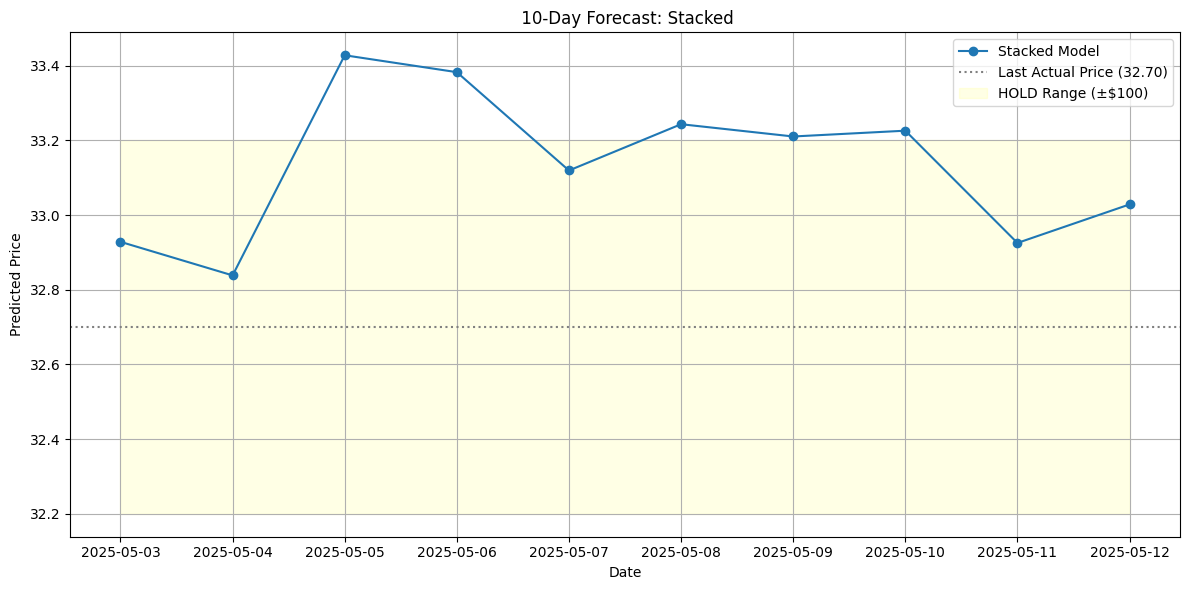

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Settings ===
n = 10  # Number of future predictions (default: 5 days)2
threshold = 0.5  # Decision threshold for recommendation

# === Prepare Future Predictions ===
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

X_combined_future = np.column_stack([future_best1_values, future_best2_values])
scaler_minmax.fit(X_combined)  # Fit on previous features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Stacked prediction
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled).flatten()
# Weighted prediction
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
# Average prediction
hybrid_average_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# === Create Forecast DataFrame ===
future_dates = pd.date_range(start=y_test.index[-1], periods=n + 1, freq='D')[1:]
future_price = pd.DataFrame({
    'Future Price_stacked': hybrid_predictions_future,
}, index=future_dates)

# === Recommendation Logic ===
last_actual_price = y_test.values[-1]
recommendations = []
for forecast in hybrid_predictions_future:
    diff = forecast - last_actual_price
    if diff > threshold:
        recommendations.append("BUY 📈")
    elif diff < -threshold:
        recommendations.append("SELL 📉")
    else:
        recommendations.append("HOLD ⚖️")
future_price['Recommendation'] = recommendations

# === Trend & Signal Logic (Bonus) ===
trend = []
for i in range(len(hybrid_predictions_future)):
    if i >= 2:
        trend_window = hybrid_predictions_future[i-2:i+1]
        if np.all(np.diff(trend_window) > 0):
            trend.append("↗️ Uptrend Detected")
        elif np.all(np.diff(trend_window) < 0):
            trend.append("↘️ Downtrend Detected")
        else:
            trend.append("")
    else:
        trend.append("")
future_price['Signal'] = trend

# === Display Summary ===
print(f"Last Actual Observed Price: {last_actual_price:.2f}\n")
print(" Predicted Future Prices and Strategy:\n")
print(future_price)

# === Plot Forecasts ===
plt.figure(figsize=(12, 6))
plt.plot(future_price.index, future_price['Future Price_stacked'], label='Stacked Model', marker='o')

plt.axhline(last_actual_price, color='gray', linestyle=':', label=f'Last Actual Price ({last_actual_price:.2f})')
plt.fill_between(future_price.index, last_actual_price + threshold, last_actual_price - threshold,
                 color='yellow', alpha=0.1, label='HOLD Range (±$100)')
plt.title(" 10-Day Forecast: Stacked")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




###  **Investment Summary – Forecast for 2025-04-16**

**Last Actual Observed Price**: $32.39

- **Predicted Price (Weighted Model)**: $32.22
   
- **Predicted Price (Stacked Model)**: $33.83
  
- **Recommendation**: **HOLD ⚖️**

---

###  **Forecast for 2025-04-17**

- **Predicted Price (Weighted Model)**: $32.23
  
- **Predicted Price (Stacked Model)**: $34.06
  
- **Recommendation**: **HOLD ⚖️**

---

###  **Conclusion**:
While the **stacked model shows a modest upward trend**, the **weighted model remains close to the current price**, indicating minimal movement. Both are **within the neutral range** (±$0.50 threshold). Therefore, no significant buy or sell signals are present at this point. The model advises **holding your current position** as market direction remains uncertain.



### Forecast with only Real Time data - LIVE

In [154]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
n = days - 7
# Define scalers
scaler_minmax = MinMaxScaler()  # For XGBoost, Random Forest
scaler_standard = StandardScaler()  # For LSTM

# Apply MinMax Scaling (for tree-based models)
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)

# Apply Standard Scaling (for LSTM)
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)

# Select features and target
commodity_data_df = commodity_data_df.drop(columns=[ 'Close' ])
live_X_train = commodity_data_df[-n:]

# Apply existing scalers (already fitted during training)
X_live_scaled_minmax = scaler_minmax.transform(live_X_train)
X_live_scaled_standard = scaler_standard.transform(live_X_train)  # If needed for LSTM

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))


In [155]:
import joblib
import pickle
import os
import pandas as pd
import numpy as np

# Define the model directory
model_dir = hybrid_models_dir.get(commodity.upper())

# Define the model directory
meta_dir = hybrid_meta_models_dir.get(commodity.upper())
hybridmodel_name = 'meta_model_'+commodity+'.pkl'
hybrid_meta_model_name = os.path.join(meta_dir, hybridmodel_name)
# Load the meta-model (used in stacked hybrid)
with open(hybrid_meta_model_name, 'rb') as f:
    meta_model = pickle.load(f)

# Function to load models
def load_saved_models(directory):
    model_files = [f for f in os.listdir(directory) if f.endswith('.pkl')]
    models = {}
    for file in model_files:
        model_path = os.path.join(directory, file)
        model_name = file.replace(".pkl", "")
        model = joblib.load(model_path)
        models[model_name] = model
    return models

# Load all saved models
loaded_models = load_saved_models(model_dir)


def predict_from_model(model_name, model):
    if "XGBOOST" in model_name.upper():
        # Use model directly without re-fitting
        xgb_predictions = model.predict(X_live_scaled_minmax)
        
        # Inverse transform predictions back to original scale
        xgb_prediction = scaler_y.inverse_transform(xgb_predictions.reshape(-1, 1)).ravel()
        return xgb_prediction

    elif "ARIMA" in model_name.upper(): 
        # Prepare exogenous variables from live data (same order as during training)
        exog_live = X_live_scaled_minmax[:, [X_train.columns.get_loc(col) for col in X_train.columns]]
        # Use pretrained ARIMA model to forecast
        steps = len(exog_live)
        model2 = model.get_forecast(steps=steps, exog=exog_live)
        fc_model2 = model2.predicted_mean
        
        return fc_model2.values

        print(f"Unknown model type for {model_name}. Skipping.")
        return None

predict_l= {}
for model_name, model in loaded_models.items():
    print(f"\nPredicting using model: {model_name}")
    prediction = predict_from_model(model_name, model)
    predict_l[model_name]=prediction
    if prediction is not None:
        print("Predicted values:", prediction)



Predicting using model: ARIMA_best-1
Predicted values: [28.76391774 28.39945179 28.59293109 28.98807985 28.92146779 29.49186192
 29.11852418 29.078794   28.90741971 29.24211351 27.34189148 26.02998391
 30.69083766 28.67629559 29.70369143 24.96449358 26.8834475  27.63343434
 27.15932577 28.33070512 27.87746807 28.3990902  28.12713051 28.23882152
 28.3823921  28.44893233 28.07537609 28.19070182 28.25090644 28.31575802
 28.99829358 28.741823   28.27068874 28.40908595 28.49669235 28.56608895
 28.02412857 28.33729352]

Predicting using model: XGBoost_best-2
Predicted values: [33.178967 32.69415  32.89769  33.032063 33.7894   34.25716  34.23644
 34.225517 33.93229  34.2562   33.036713 30.46137  33.836563 32.84191
 34.160076 28.173912 28.602568 30.121328 29.590395 30.977123 31.03826
 31.507923 31.453876 31.490725 31.658493 32.289646 32.276287 32.260635
 32.273083 32.32665  32.92026  32.92395  32.519535 32.246456 32.50951
 32.56228  32.289417 32.29711 ]


C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Lenovo\myvenv\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [156]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Get individual model forecasts
best1_forecast_trimmed, best2_forecast_trimmed = list(predict_l.values())

# Ensure both forecasts are the same length
min_length = min(len(best1_forecast_trimmed), len(best2_forecast_trimmed))

best1_forecast_trimmed = best1_forecast_trimmed[:min_length]
best2_forecast_trimmed = best2_forecast_trimmed[:min_length]

# Now combine
X_combined = np.column_stack((best1_forecast_trimmed, best2_forecast_trimmed))

# Normalize features
X_combined_scaled = scaler_minmax.fit_transform(X_combined)

# Predict using stacked model
hybrid_predictions_stacked = meta_model.predict(X_combined_scaled)


In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n = 24  # Number of future predictions
threshold = 0.2  # Decision threshold for recommendation

# === Prepare Future Predictions ===
future_best1_values = np.array(best1_forecast_trimmed[-n:]).reshape(-1, 1)
future_best2_values = np.array(best2_forecast_trimmed[-n:]).reshape(-1, 1)

X_combined_future = np.column_stack([future_best1_values, future_best2_values])
scaler_minmax.fit(X_combined)  # Fit on previous features
X_combined_future_scaled = scaler_minmax.transform(X_combined_future)

# Stacked prediction
hybrid_predictions_future = meta_model.predict(X_combined_future_scaled).flatten()
# Weighted prediction
hybrid_weighted_future = (weight_best1 * future_best1_values.flatten()) + (weight_best2 * future_best2_values.flatten())
# Average prediction
hybrid_average_future = (future_best1_values.flatten() + future_best2_values.flatten()) / 2

# === Create Forecast DataFrame ===
# Ensure future dates are hourly starting from the last actual date in y_test
last_actual_date = y_test.index[-1]  # Get the last date from y_test
future_dates = pd.date_range(start=last_actual_date, periods=n, freq='H')  # Hourly frequency
future_price = pd.DataFrame({
    'Future Price_stacked': hybrid_predictions_future,
}, index=future_dates)

# === Recommendation Logic ===
last_actual_price = y_test.values[-1]
recommendations = []
for forecast in hybrid_predictions_future:
    diff = forecast - last_actual_price
    if diff > threshold:
        recommendations.append("BUY")
    elif diff < -threshold:
        recommendations.append("SELL")
    else:
        recommendations.append("HOLD")
future_price['Recommendation'] = recommendations

# === Trend & Signal Logic (Bonus) ===
trend = []
for i in range(len(hybrid_predictions_future)):
    if i >= 2:
        trend_window = hybrid_predictions_future[i-2:i+1]
        if np.all(np.diff(trend_window) > 0):
            trend.append("↗️ Uptrend Detected")
        elif np.all(np.diff(trend_window) < 0):
            trend.append("↘️ Downtrend Detected")
        else:
            trend.append("")
    else:
        trend.append("")
future_price['Signal'] = trend



future_price

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25220\2844130378.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_actual_date, periods=n, freq='H')  # Hourly frequency


,Future Price_stacked,Recommendation,Signal
2025-05-02 00:00:00,34.602083,BUY,
2025-05-02 01:00:00,29.060567,SELL,
2025-05-02 02:00:00,29.420067,SELL,
2025-05-02 03:00:00,30.836703,SELL,↗️ Uptrend Detected
2025-05-02 04:00:00,30.346477,SELL,
2025-05-02 05:00:00,31.628463,SELL,
2025-05-02 06:00:00,31.696909,SELL,↗️ Uptrend Detected
2025-05-02 07:00:00,32.128148,SELL,↗️ Uptrend Detected
2025-05-02 08:00:00,32.083529,SELL,
2025-05-02 09:00:00,32.115691,SELL,


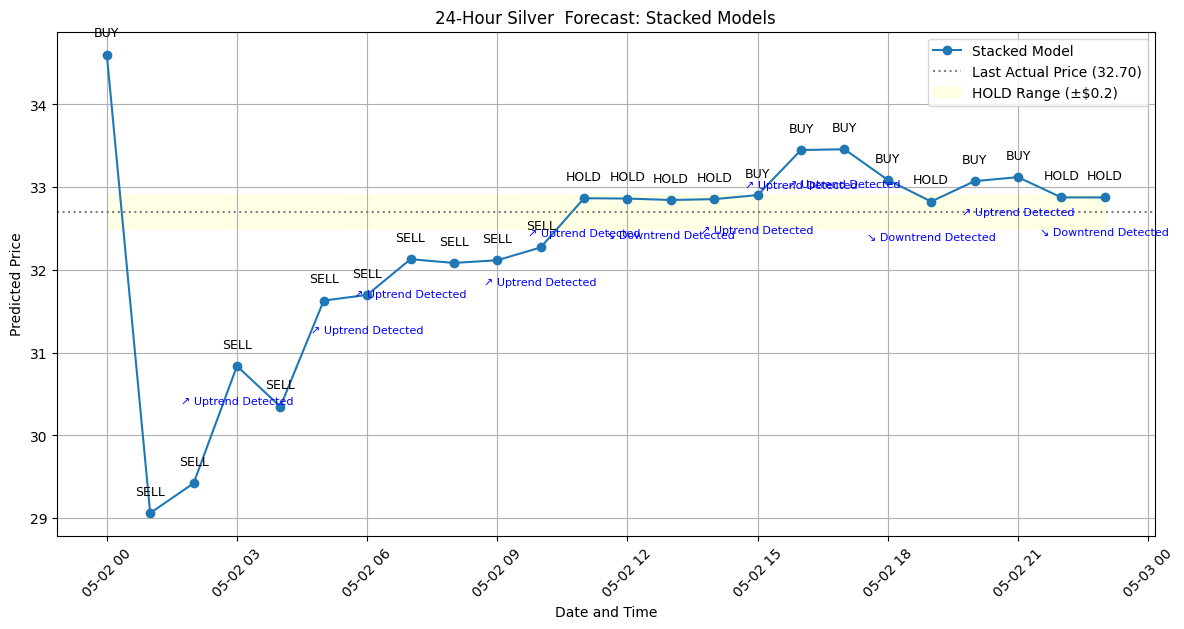

In [166]:
plt.figure(figsize=(12, 6))
plt.plot(future_price.index, future_price['Future Price_stacked'], label='Stacked Model', marker='o')

plt.axhline(last_actual_price, color='gray', linestyle=':', label=f'Last Actual Price ({last_actual_price:.2f})')
plt.fill_between(future_price.index, last_actual_price + threshold, last_actual_price - threshold,
                 color='yellow', alpha=0.1, label='HOLD Range (±$0.2)')
plt.title(f"{n}-Hour Silver  Forecast: Stacked Models")
plt.xlabel("Date and Time")
plt.ylabel("Predicted Price")
plt.legend()
plt.grid(True)
plt.tight_layout()

# === Add Annotations with Boundary-Aware Positioning ===
ymin, ymax = plt.ylim()
text_offset = (ymax - ymin) * 0.03  # dynamic offset ~3% of range

for x, y, rec, sig in zip(future_price.index, 
                          future_price['Future Price_stacked'], 
                          future_price['Recommendation'], 
                          future_price['Signal']):
    # Calculate safe y-position for text (avoid going above ymax)
    y_text = y + text_offset
    if y_text > ymax:
        y_text = y - text_offset * 2  # put below if too high

    plt.text(x, y_text, rec, fontsize=9, ha='center', va='bottom')

    # Optional: show signal trend below the point
    if sig:
        plt.text(x, y - text_offset * 2, sig, fontsize=8, ha='center', va='top', color='blue')

# Optional: Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()
